# ロジスティック回帰の平均限界効果

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy.stats as ss

## パラメータの設定

In [2]:
result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## データの取得

In [3]:
cancer = load_breast_cancer()
cancer_data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_data['y'] = cancer.target

In [4]:
cancer_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
cancer_data.shape

(569, 31)

In [6]:
tmp = cancer_data.loc[:, ['y']]
tmp['cnt'] = 1
tmp.groupby('y').count()

,cnt
y,
0,212
1,357


## 学習データの作成

In [7]:
X_data = cancer_data.drop(columns='y')
y_data = cancer_data['y'].tolist()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data,
    y_data,
    test_size=0.3,
    random_state=42
)

## モデルの構築

In [9]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

print('正答率:{:.0f}%'.format(
    model.score(X_test, y_test)* 100
))

正答率:98%


## 結果の確認

In [10]:
def calc_logistic_p_value(model, X, alpha=0.05):
    
    denom = (2.0 * (1.0 + np.cosh(model.decision_function(X))))
    denom = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    
    coefs = model.coef_[0]
    n = len(X)
    z_scores = coefs/sigma_estimates # z-score for eaach model coefficient
    p_values = [ss.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
    
    z_ = ss.norm.ppf(1-alpha/2)

    uppers = coefs + z_ * sigma_estimates
    lowers = coefs - z_ * sigma_estimates
    
    return pd.DataFrame({
        'colname' : X.columns.tolist(),
        'coef' : coefs,
        'sigma' : sigma_estimates,
        'z_score' : z_scores,
        'p_values' : p_values,
        'lower_{:.3f}'.format(alpha/2)  : lowers,
        'upper_{:.3f}'.format(1-alpha/2) : uppers,
        'significant' : ['*' if x <= alpha else '' for x in p_values]
    })

In [11]:
result = calc_logistic_p_value(
    model=model,
    X=X_train,
    y=y_train,
    alpha=0.05
)
result.to_csv(result_dir_path.joinpath('logit_summary.csv'), index=False)
result

,colname,coef,sigma,z_score,p_values,lower_0.025,upper_0.975,significant
0,mean radius,1.078052,8.084785,0.133343,0.893922,-14.767835,16.923940,
1,mean texture,0.225257,0.218871,1.029175,0.303398,-0.203723,0.654236,
2,mean perimeter,-0.388228,1.108112,-0.350350,0.726076,-2.560088,1.783633,
3,mean area,0.025766,0.028496,0.904194,0.365893,-0.030085,0.081617,
4,mean smoothness,-0.136790,74.542174,-0.001835,0.998536,-146.236766,145.963187,
5,mean compactness,-0.243047,46.832950,-0.005190,0.995859,-92.033944,91.547849,
6,mean concavity,-0.518212,37.710614,-0.013742,0.989036,-74.429658,73.393233,
7,mean concave points,-0.277049,72.582437,-0.003817,0.996954,-142.536011,141.981913,
8,mean symmetry,-0.219390,24.072630,-0.009114,0.992728,-47.400878,46.962099,
9,mean fractal dimension,-0.038466,167.610088,-0.000229,0.999817,-328.548201,328.471270,


In [12]:
def calc_marginal_probability_effect(model, X, alpha=0.05):
    
    predict_values = model.predict_proba(X)[:, 1]
    predict_values = predict_values * (1 - predict_values)
    
    mpe = np.tile(predict_values.reshape((-1, 1)), X.shape[1]) * model.coef_[0]
    
    n = len(X)
    ampes = mpe.mean(axis=0)
    stds = mpe.std(axis=0)
    
    t_values = ampes / (stds/np.sqrt(n-1))
    p_values = [1 - ss.t.cdf(x, df=n-1) if x > 0 else ss.t.cdf(x, df=n-1) for x in t_values]
    
    t_ = ss.t.ppf(1-alpha/2, df=n-1)

    uppers = ampes + t_ * (stds/np.sqrt(n-1))
    lowers = ampes - t_ * (stds/np.sqrt(n-1))
    
    return pd.DataFrame({
        'colname' : X_data.columns.tolist(),
        'coef' : model.coef_[0],
        'ampe' : ampes,
        'mpe_std' : stds,
        't_value' : t_values,
        'p_value' : p_values,
        'lower_{:.3f}'.format(alpha/2)  : lowers,
        'upper_{:.3f}'.format(1-alpha/2) : uppers,
        'significant' : ['*' if x <= alpha else '' for x in p_values]
    })

In [13]:
result = calc_marginal_probability_effect(
    model=model,
    X=X_train,
    alpha=0.05
)
result = result.sort_values('ampe')
result.to_csv(result_dir_path.joinpath('logit_ampe.csv'), index=False)
result

,colname,coef,ampe,mpe_std,t_value,p_value,lower_0.025,upper_0.975,significant
26,worst concavity,-1.350141,-0.046996,0.089856,-10.420917,6.113983e-23,-0.055862,-0.038130,*
25,worst compactness,-0.734056,-0.025551,0.048854,-10.420917,6.113983e-23,-0.030371,-0.020731,*
28,worst symmetry,-0.718204,-0.024999,0.047799,-10.420917,6.113983e-23,-0.029715,-0.020283,*
6,mean concavity,-0.518212,-0.018038,0.034489,-10.420917,6.113983e-23,-0.021441,-0.014635,*
27,worst concave points,-0.499871,-0.017400,0.033268,-10.420917,6.113983e-23,-0.020682,-0.014117,*
21,worst texture,-0.498958,-0.017368,0.033207,-10.420917,6.113983e-23,-0.020644,-0.014091,*
2,mean perimeter,-0.388228,-0.013513,0.025838,-10.420917,6.113983e-23,-0.016063,-0.010964,*
7,mean concave points,-0.277049,-0.009644,0.018438,-10.420917,6.113983e-23,-0.011463,-0.007824,*
24,worst smoothness,-0.274445,-0.009553,0.018265,-10.420917,6.113983e-23,-0.011355,-0.007751,*
5,mean compactness,-0.243047,-0.008460,0.016176,-10.420917,6.113983e-23,-0.010056,-0.006864,*


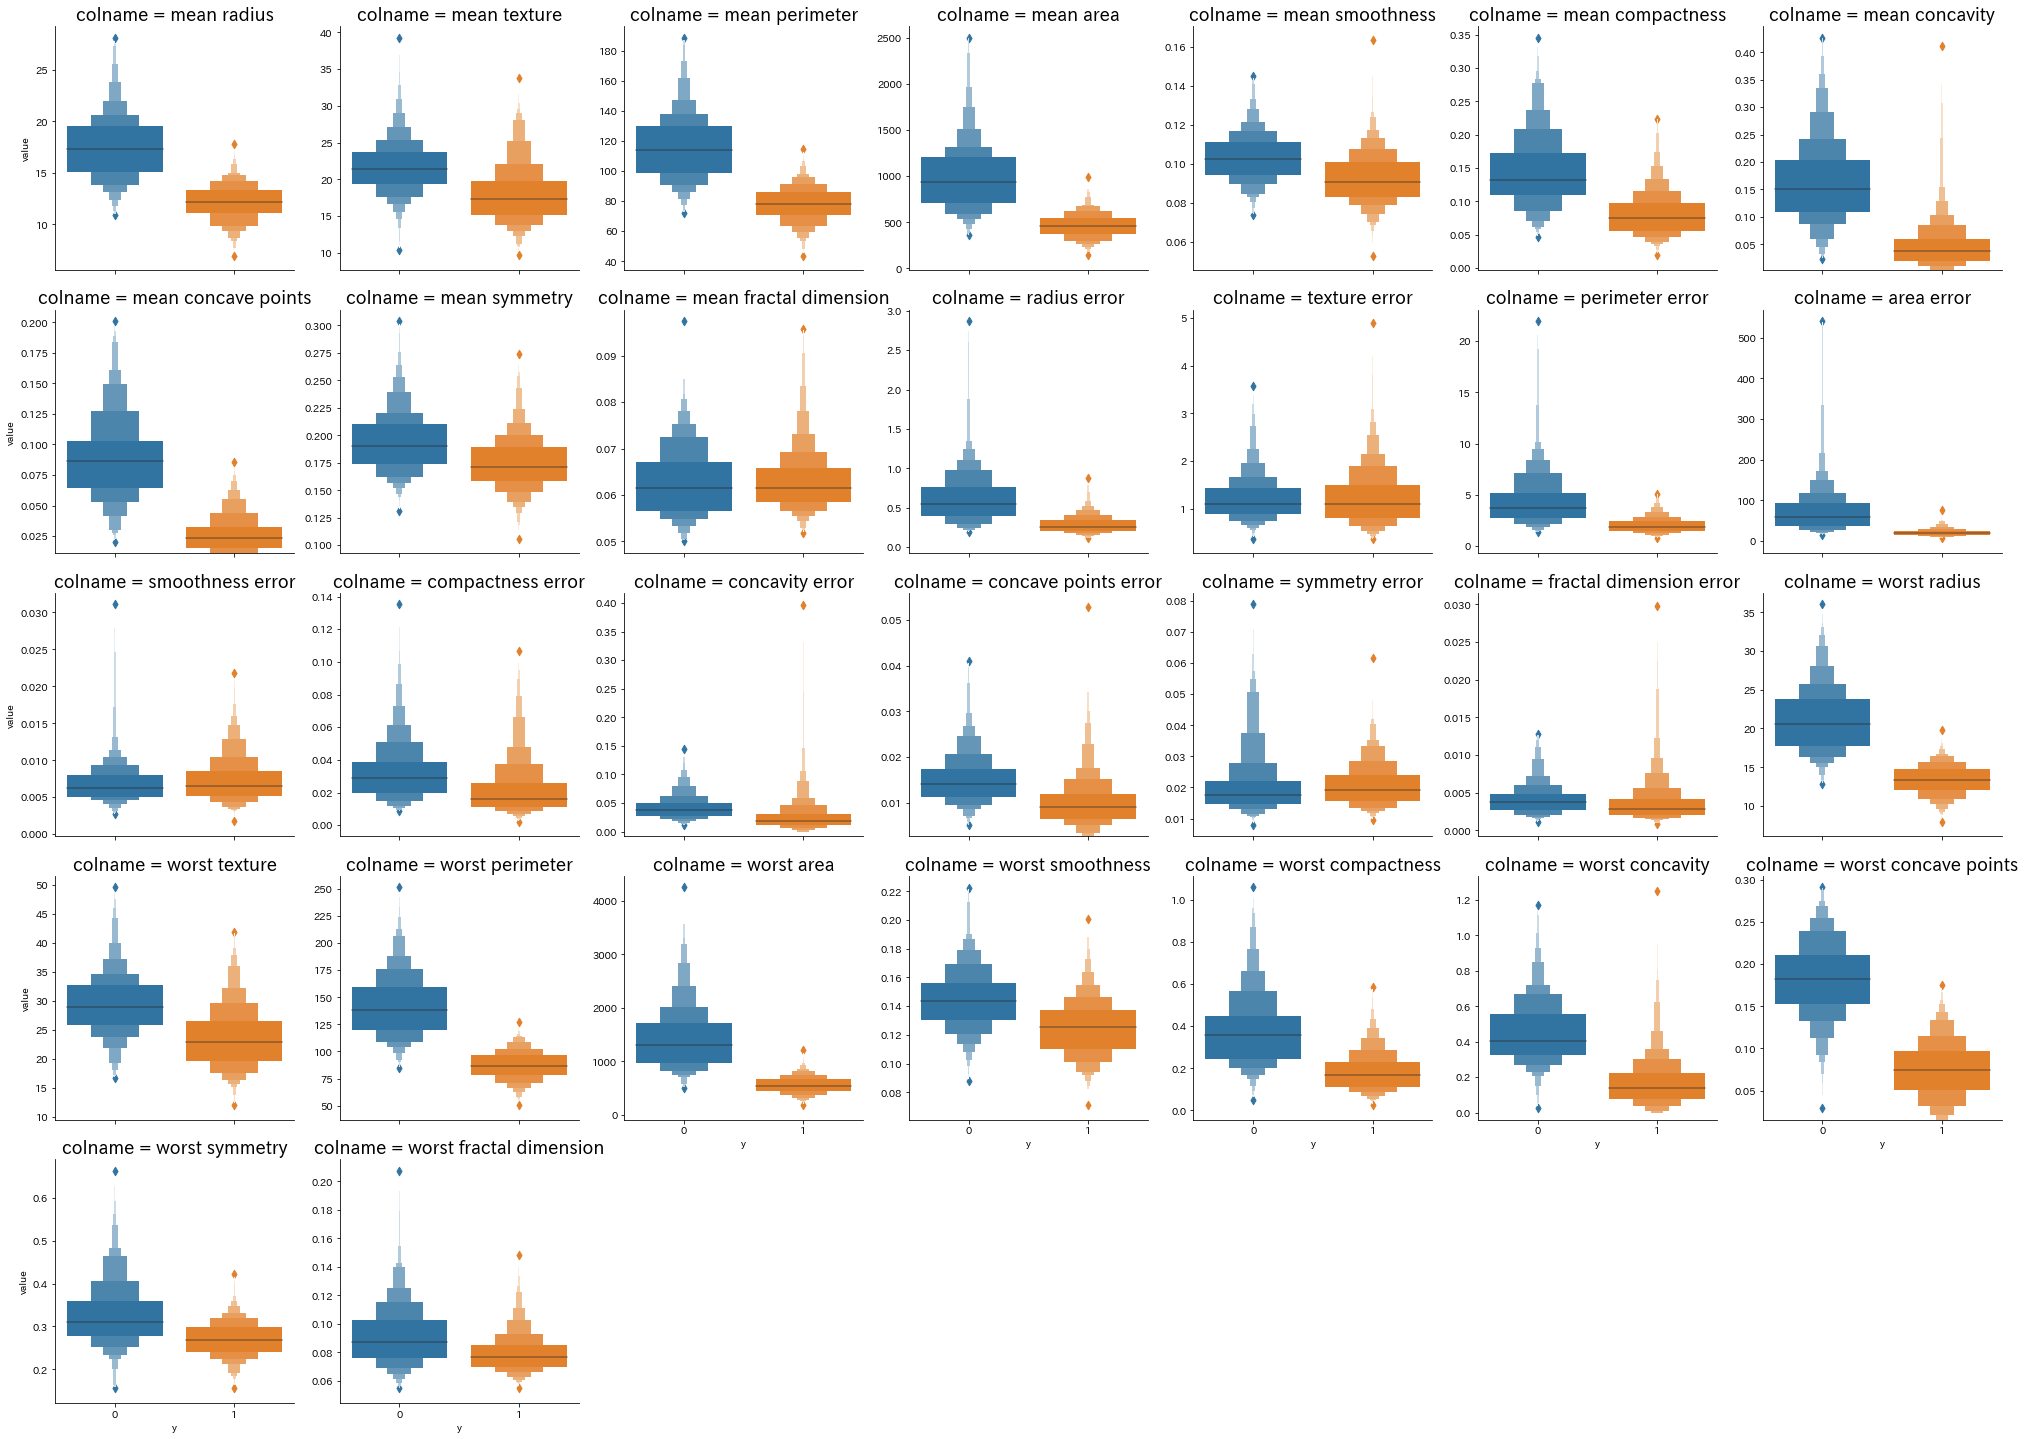

In [14]:
target_data = cancer_data.set_index('y')
target_data = target_data.stack()
target_data = target_data.reset_index()
target_data.columns = ['y', 'colname', 'value']

g = sns.catplot(
    data=target_data,
    x='y',
    y='value',
    col='colname',
    col_wrap=7,
    kind='boxen',
    sharey=False,
    height=4
)
g.set_titles(size=18)
plt.savefig(result_dir_path.joinpath('variable_graph.png').__str__())
g

In [15]:
target_data = cancer_data.set_index('y')
target_data = target_data.stack()
target_data = target_data.reset_index()
target_data.columns = ['y', 'colname', 'value']

target_data = target_data.groupby(['y', 'colname']).agg({
    'value' : ['mean', 'median', 'std']
})
target_data.columns = ['{}_{}'.format(col[0], col[1]) for col in target_data.columns]
target_data = target_data.reset_index()

target_data = pd.pivot_table(
    data=target_data,
    columns='y',
    index='colname'
)